In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training Utilities

In [6]:
import numpy as np
import torch
import torch.nn as nn
# from torch.optim import Adam, LBFGS, Optimizer
from torch.optim import Optimizer
from torch.optim import Adam
from src.opts.polyak_lbfgs import PolyakLBFGS
from src.opts.polyak_gd import PolyakGD
from src.opts.alr_mag import ALRMAG
from src.opts.sketchygn import SketchyGN
import random
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

'''
Implementation of PINNs. 

Source: https://github.com/AdityaLab/pinnsformer/blob/main/model/pinn.py
'''
class PINN(nn.Module):
  def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
    super(PINN, self).__init__()

    layers = []
    for i in range(num_layer-1):
      if i == 0:
        layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
        layers.append(nn.Tanh())
      else:
        layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
        layers.append(nn.Tanh())

    layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

    self.linear = nn.Sequential(*layers)

  def forward(self, x, t):
    src = torch.cat((x,t), dim=-1)
    return self.linear(src)

class Adam_LBFGS(Optimizer):
    def __init__(self, params, switch_epoch, adam_params, lbfgs_params):
        # defaults = dict(switch_epoch=switch_epoch, adam_params=adam_params, lbfgs_params=lbfgs_params)

        self.switch_epoch = switch_epoch
        self.params = list(params)
        self.adam = Adam(self.params, **adam_params)
        self.lbfgs = PolyakLBFGS(self.params, **lbfgs_params)
        print(lbfgs_params)
        self.lbfgs_params = lbfgs_params

        super(Adam_LBFGS, self).__init__(self.params, defaults={})

        self.state['epoch'] = 0

    def step(self, closure=None):
        if self.state['epoch'] < self.switch_epoch:
            self.adam.step(closure)
        else:
            if self.state['epoch'] == self.switch_epoch:
                print(f'Switching to LBFGS optimizer at epoch {self.state["epoch"]}')
                # opt = LBFGS(self.adam.param_groups[0]["params"], **self.lbfgs_params)
                # assert opt.state_dict() == self.lbfgs.state_dict()
            self.lbfgs.step(closure)

        self.state['epoch'] += 1

class Adam_PolyakGD(Optimizer):
    def __init__(self, params, switch_epoch, adam_params):
        self.switch_epoch = switch_epoch
        self.params = list(params)
        self.adam = Adam(self.params, **adam_params)
        self.polyakgd = PolyakGD(self.params)

        super(Adam_PolyakGD, self).__init__(self.params, defaults={})

        self.state['epoch'] = 0

    def step(self, closure=None):
        if self.state['epoch'] < self.switch_epoch:
            self.adam.step(closure)
        else:
            if self.state['epoch'] == self.switch_epoch:
                print(
                    f'Switching to PolyakGD optimizer at epoch {self.state["epoch"]}')
            self.polyakgd.step(closure)

        self.state['epoch'] += 1

class Adam_ALRMAG(Optimizer):
    def __init__(self, params, switch_epoch, adam_params, alrmag_params):
        self.switch_epoch = switch_epoch
        self.params = list(params)
        self.adam = Adam(self.params, **adam_params)
        self.alrmag = ALRMAG(self.params, **alrmag_params)

        super(Adam_ALRMAG, self).__init__(self.params, defaults={})

        self.state['epoch'] = 0

    def step(self, closure=None):
        if self.state['epoch'] < self.switch_epoch:
            self.adam.step(closure)
        else:
            if self.state['epoch'] == self.switch_epoch:
                print(
                    f'Switching to ALRMAG optimizer at epoch {self.state["epoch"]}')
            self.alrmag.step(closure)

        self.state['epoch'] += 1

"""
Helper function for obtaining corresponding domain and loss function of the chosen PDE type. 

INPUT: 
- pde_name: string; name of the PDE problem
- pde_params_list: list of strings; coefficients of the PDE
- loss_name: string; name of the loss type
OUTPUT: 
- x_range: list of size 2; lower and upper bounds of spatial variable x
- t_range: list of size 2; lower and upper bounds of temporal variable t
- loss_func: loss function that takes (x,t,pred) and computes the total loss
- pde_coefs: dictionary containing coefficients of the PDE
"""
def get_pde(pde_name, pde_params_list, loss_name): 
    # determine loss type
    loss_options = {
        "l1": {"res": nn.L1Loss(), "bc": nn.L1Loss(), "ic": nn.L1Loss()},
        "mse": {"res": nn.MSELoss(), "bc": nn.MSELoss(), "ic": nn.MSELoss()},
        "huber": {"res": nn.HuberLoss(), "bc": nn.HuberLoss(), "ic": nn.HuberLoss()},
        "hybrid": {"res": nn.HuberLoss(), "bc": nn.MSELoss(), "ic": nn.MSELoss()}
    }
    try: 
        loss_type = loss_options[loss_name]
    except KeyError as ke:
        raise RuntimeError("{} is not a valid loss type.".format(ke))

    # parse PDE parameters
    pde_coefs = parse_params_list(pde_params_list)
    
    # determine pde type
    if pde_name == "convection": 
        if "beta" not in pde_coefs.keys(): 
            raise KeyError("beta is not specified for convection PDE.")

        x_range = [0, 2 * np.pi]
        t_range = [0, 1]

        def loss_func(x, t, pred): 
            x_res, x_left, x_upper, x_lower = x
            t_res, t_left, t_upper, t_lower = t
            outputs_res, outputs_left, outputs_upper, outputs_lower = pred

            u_x = torch.autograd.grad(outputs_res, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(outputs_res, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]

            loss_res = loss_type["res"](u_t + pde_coefs["beta"] * u_x, torch.zeros_like(u_t))
            loss_bc = loss_type["bc"](outputs_upper - outputs_lower, torch.zeros_like(outputs_upper))
            loss_ic = loss_type["ic"](outputs_left[:,0], torch.sin(x_left[:,0]))

            # loss = loss_res + loss_bc + loss_ic

            return loss_res, loss_bc, loss_ic

    elif pde_name == "reaction_diffusion": 
        if not {"nu", "rho"} <= pde_coefs.keys(): 
            raise KeyError("nu or rho is not specified for reaction diffusion PDE.")

        x_range = [0, 2 * np.pi]
        t_range = [0, 1]

        def loss_func(x, t, pred): 
            x_res, x_left, x_upper, x_lower = x
            t_res, t_left, t_upper, t_lower = t
            outputs_res, outputs_left, outputs_upper, outputs_lower = pred

            u_x = torch.autograd.grad(outputs_res, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(outputs_res, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]

            loss_res = loss_type["res"](u_t - pde_coefs["nu"] * u_xx - pde_coefs["rho"] * outputs_res * (1 - outputs_res), torch.zeros_like(u_t))
            loss_bc = loss_type["bc"](outputs_upper - outputs_lower, torch.zeros_like(outputs_upper))
            loss_ic = loss_type["ic"](outputs_left[:,0], torch.exp(-(1/2) * torch.square((x_left[:,0] - np.pi) / (np.pi / 4))))

            # loss = loss_res + loss_bc + loss_ic

            return loss_res, loss_bc, loss_ic

    elif pde_name == "reaction": 
        if "rho" not in pde_coefs.keys(): 
            raise KeyError("rho is not specified for reaction PDE.")

        x_range = [0, 2 * np.pi]
        t_range = [0, 1]

        def loss_func(x, t, pred): 
            x_res, x_left, x_upper, x_lower = x
            t_res, t_left, t_upper, t_lower = t
            outputs_res, outputs_left, outputs_upper, outputs_lower = pred

            u_t = torch.autograd.grad(outputs_res, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]

            loss_res = loss_type["res"](u_t - pde_coefs["rho"] * outputs_res * (1 - outputs_res), torch.zeros_like(u_t))
            loss_bc = loss_type["bc"](outputs_upper - outputs_lower, torch.zeros_like(outputs_upper))
            loss_ic = loss_type["ic"](outputs_left[:,0], torch.exp(-(1/2) * torch.square((x_left[:,0] - np.pi) / (np.pi / 4))))

            # loss = loss_res + loss_bc + loss_ic

            return loss_res, loss_bc, loss_ic

    elif pde_name == "wave":
        if "beta" not in pde_coefs.keys():
            raise KeyError("beta is not specified for wave PDE.")

        x_range = [0, 1]
        t_range = [0, 1]

        def loss_func(x, t, pred):
            x_res, x_left, x_upper, x_lower = x
            t_res, t_left, t_upper, t_lower = t
            outputs_res, outputs_left, outputs_upper, outputs_lower = pred

            u_x = torch.autograd.grad(outputs_res, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(outputs_res, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]
            u_tt = torch.autograd.grad(u_t, t_res, grad_outputs=torch.ones_like(outputs_res), retain_graph=True, create_graph=True)[0]

            loss_res = loss_type["res"](u_tt - 4 * u_xx, torch.zeros_like(u_tt))
            loss_bc = loss_type["bc"](outputs_upper, torch.zeros_like(outputs_upper)) + loss_type["bc"](outputs_lower, torch.zeros_like(outputs_lower))

            ui_t = torch.autograd.grad(outputs_left, t_left, grad_outputs=torch.ones_like(outputs_left), retain_graph=True, create_graph=True)[0]

            loss_ic_1 = loss_type["ic"](outputs_left[:,0], torch.sin(np.pi * x_left[:,0]) + 0.5 * torch.sin(pde_coefs["beta"] * np.pi * x_left[:,0]))
            loss_ic_2 = loss_type["ic"](ui_t, torch.zeros_like(ui_t))

            loss_ic = loss_ic_1 + loss_ic_2

            return loss_res, loss_bc, loss_ic

    else: 
        raise RuntimeError("{} is not a valid PDE name.".format(pde_name))

    return x_range, t_range, loss_func, pde_coefs

"""
Helper function for computing reference solution to the given PDE at given points. 

INPUT: 
- pde_name: string; name of the PDE problem
- pde_coefs: dictionary containing coefficients of the PDE
- x: tuple of (x_res, x_left, x_upper, x_lower)
- t: tuple of (t_res, t_left, t_upper, t_lower)
- data_params: dictionary containing parameters used to generate the data
OUTPUT: 
- sol: 
"""
def get_ref_solutions(pde_name, pde_coefs, x, t, data_params): 
    if pde_name == "convection": 
        sol = np.vstack([np.sin(x[i].cpu().detach().numpy() - pde_coefs["beta"] * t[i].cpu().detach().numpy()) for i in range(len(x))])
    
    elif pde_name == "reaction_diffusion": 
        # unpack data-generation parameters
        x_range = data_params["x_range"]
        t_range = data_params["t_range"]
        x_num = data_params["x_num"]
        t_num = data_params["t_num"]
        res_idx = data_params["res_idx"]
        # generate grid
        x = np.linspace(x_range[0], x_range[1], x_num-1, endpoint=False).reshape(-1, 1) # exclude upper boundary
        t = np.linspace(t_range[0], t_range[1], t_num).reshape(-1, 1)
        x_mesh, t_mesh = np.meshgrid(x, t)
        # compute initial solution
        u0 = np.exp(-(1/2) * np.square((x - np.pi) / (np.pi / 4))).flatten()
        u = np.zeros((x_num, t_num))
        u[:-1,0] = u0

        IKX_pos = 1j * np.arange(0, (x_num-1) / 2 + 1, 1)
        IKX_neg = 1j * np.arange(-(x_num-1) / 2 + 1, 0, 1)
        IKX = np.concatenate((IKX_pos, IKX_neg))
        IKX2 = IKX * IKX
        # perform time-marching
        t_step_size = (t_range[1] - t_range[0]) / (t_num - 1)
        u_t = u0.copy()
        for i in range(t_num - 1): 
            # reaction component
            factor = u_t * np.exp(pde_coefs['rho'] * t_step_size)
            u_t = factor / (factor + (1 - u_t))
            # diffusion component
            factor = np.exp(pde_coefs['nu'] * IKX2 * t_step_size)
            u_hat = np.fft.fft(u_t) * factor
            u_t = np.real(np.fft.ifft(u_hat))
            u[:-1,i+1] = u_t

        # add back solution on the upper boundary using the periodic boundary condition
        u[-1,:] = u[0,:]
        # split the solution
        sol_left = u[:,0].reshape(-1,1)
        sol_upper = u[-1,:].reshape(-1,1)
        sol_lower = u[0,:].reshape(-1,1)
        sol_res = u[1:-1, 1:].T.reshape(-1,1)[res_idx]

        sol = np.vstack([sol_res, sol_left, sol_upper, sol_lower])
    
    elif pde_name == "reaction": 
        def compute_sol(x, t): 
            initial_func_term = np.exp(-(1/2) * np.square((x - np.pi) / (np.pi / 4)))
            exp_term = np.exp(pde_coefs['rho'] * t)
            return initial_func_term * exp_term / (initial_func_term * exp_term + 1 - initial_func_term)
        
        sol = np.vstack([compute_sol(x[i].cpu().detach().numpy(), t[i].cpu().detach().numpy()) for i in range(len(x))])

    elif pde_name == "wave":
        def compute_sol(x, t):
            return np.sin(np.pi * x) * np.cos(2 * np.pi * t) \
                + 0.5 * np.sin(pde_coefs["beta"] * np.pi * x) * np.cos(2 * pde_coefs["beta"] * np.pi * t)

        sol = np.vstack([compute_sol(x[i].cpu().detach().numpy(), t[i].cpu().detach().numpy()) for i in range(len(x))])

    else: 
        raise RuntimeError("{} is not a valid PDE name.".format(pde_name))
    
    return sol

"""
Helper function for setting seed for the random number generator in various packages.

INPUT: 
- seed: integer
"""
def set_random_seed(seed): 
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

"""
Helper function for generating data on a grid. 

INPUT: 
- x_range: list of size 2; lower and upper bounds of spatial variable x
- t_range: list of size 2; lower and upper bounds of temporal variable t
- x_num: positive integer; number of x points
- t_num: positive integer; number of t points
- random: boolean; indication whether to (uniformly) randomly from the grid
- num_res_samples: positive integer; number of random samples to draw for residual points
- device: string; the device that the samples will be stored at
OUTPUT: 
- x: tuple of (x_res, x_left, x_upper, x_lower)
- t: tuple of (t_res, t_left, t_upper, t_lower)
- data_params: dictionary containing parameters used to generate the data 
               including x_range, t_range, x_num, t_num, grid_multiplier, and res_idx
where: 
> res: numpy array / tensor of size (x_num-2)(t_num-1) * 2 or num_res_samples * 2; residual points (interior grid or random samples from it)
> b_left: numpy array / tensor of size (x_num) * 2; initial points (corresponding to initial time step)
> b_upper: numpy array / tensor of size (t_num) * 2; upper boundary points
> b_lower: numpy array / tensor of size (t_num) * 2; lower boundary points
> res_idx: numpy array of length (x_num-2)(t_num-1) or num_res_samples; corresponding indices of the sampled residual points from the interior grid
"""
def get_data(x_range, t_range, x_num, t_num, random=False, num_res_samples=1e4, device='cpu'):
    # generate initial and boundary points
    x = np.linspace(x_range[0], x_range[1], x_num).reshape(-1, 1)
    t = np.linspace(t_range[0], t_range[1], t_num).reshape(-1, 1)
    # initial time
    x_left = x.copy()
    t_left = t_range[0] * np.ones([x_num,1])
    # lower boundary
    x_lower = x_range[0] * np.ones([t_num,1])
    t_lower = t.copy()
    # upper boundary
    x_upper = x_range[1] * np.ones([t_num,1])
    t_upper = t.copy()
    # residual points
    x_mesh, t_mesh = np.meshgrid(x[1:-1], t[1:])
    data_params = {
        "x_range": x_range, 
        "t_range": t_range, 
        "x_num": x_num, 
        "t_num": t_num
    }
    if random: 
        mesh = np.hstack((x_mesh.flatten()[:, None], t_mesh.flatten()[:, None]))
        idx = np.random.choice(mesh.shape[0], num_res_samples, replace=False)
        x_res = mesh[idx, 0:1]
        t_res = mesh[idx, 1:2]
        data_params["res_idx"] = idx
    else: 
        x_res = x_mesh.reshape(-1,1)
        t_res = t_mesh.reshape(-1,1)
        data_params["res_idx"] = np.arange((x_num - 2) * (t_num - 1))

    # move data to target device
    if device != 'cpu': 
        x_left = torch.tensor(x_left, dtype=torch.float32, requires_grad=True).to(device)
        t_left = torch.tensor(t_left, dtype=torch.float32, requires_grad=True).to(device)
        x_upper = torch.tensor(x_upper, dtype=torch.float32, requires_grad=True).to(device)
        t_upper = torch.tensor(t_upper, dtype=torch.float32, requires_grad=True).to(device)
        x_lower = torch.tensor(x_lower, dtype=torch.float32, requires_grad=True).to(device)
        t_lower = torch.tensor(t_lower, dtype=torch.float32, requires_grad=True).to(device)
        x_res = torch.tensor(x_res, dtype=torch.float32, requires_grad=True).to(device)
        t_res = torch.tensor(t_res, dtype=torch.float32, requires_grad=True).to(device)

    # form tuples
    x = (x_res, x_left, x_upper, x_lower)
    t = (t_res, t_left, t_upper, t_lower)

    return x, t, data_params

"""
Helper function for initializing neural net parameters. 
"""
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0)

"""
Helper function for making predictions with PINN. 

INPUT: 
- x: tutple of (x_res, x_left, x_upper, x_lower)
- t: tutple of (t_res, t_left, t_upper, t_lower)
- model: PINN model
OUTPUT: 
- preds: tuple of (pred_res, pred_left, pred_upper, pred_lower)
where: 
> pred_res: predictions on residual points
> pred_left: predictions on initial points
> pred_upper: predictions on upper boundary points
> pred_lower: predictions on lower boundary points
"""
def predict(x, t, model): 
    x_res, x_left, x_upper, x_lower = x
    t_res, t_left, t_upper, t_lower = t
    
    pred_res = model(x_res, t_res)
    pred_left = model(x_left, t_left)
    pred_upper = model(x_upper, t_upper)
    pred_lower = model(x_lower, t_lower)
    
    preds = (pred_res, pred_left, pred_upper, pred_lower) 
    
    return preds

"""
Helper function for computing l1 relative error. 

INPUT: 
- prediction: numpy array of predictions from the model
- target: numpy array of ground truths
OUTPUT: 
- error: scalar; computed relative error
"""
def l1_relative_error(prediction, target): 
    return np.sum(np.abs(target-prediction)) / np.sum(np.abs(target))

"""
Helper function for computing l2 relative error. 

INPUT: 
- prediction: numpy array of predictions from the model
- target: numpy array of ground truths
OUTPUT: 
- error: scalar; computed relative error
"""
def l2_relative_error(prediction, target): 
    return np.sqrt(np.sum((target-prediction)**2) / np.sum(target**2))

"""
Helper function for initializing the optimizer with specified parameters. 

INPUT: 
- opt_name: string; name of the optimizer
- opt_params: dictionary; arguments used to initialize the optimizer
- model_params: dictionary; contains Tensors of the model to be optimized
OUTPUT: 
- opt: torch.optim.Optimizer instance
"""
def get_opt(opt_name, opt_params, model_params):
    if opt_name == 'adam':
        return Adam(model_params, **opt_params)
    elif opt_name == 'lbfgs':
        if "history_size" in opt_params:
            opt_params["history_size"] = int(opt_params["history_size"])
        return LBFGS(model_params, **opt_params, line_search_fn='strong_wolfe')
    elif opt_name == 'polyak_gd':
        return PolyakGD(model_params, **opt_params)
    elif opt_name == 'alr_mag':
        return ALRMAG(model_params, **opt_params)
    elif opt_name == 'adam_lbfgs':
        if "switch_epoch" not in opt_params:
            raise KeyError("switch_epoch is not specified for Adam_LBFGS optimizer.")
        switch_epoch = opt_params["switch_epoch"]

        # Get parameters for Adam and LBFGS, remove the prefix "adam_" and "lbfgs_" from the keys
        adam_params = {k[5:]: v for k, v in opt_params.items() if k.startswith("adam_")}
        lbfgs_params = {k[6:]: v for k, v in opt_params.items() if k.startswith("lbfgs_")}
        lbfgs_params["line_search_fn"] = "strong_wolfe_pp"
        
        # If max_iter or history_size is specified, convert them to integers
        if "max_iter" in lbfgs_params:
            lbfgs_params["max_iter"] = int(lbfgs_params["max_iter"])
        if "history_size" in lbfgs_params:
            lbfgs_params["history_size"] = int(lbfgs_params["history_size"])

        return Adam_LBFGS(model_params, switch_epoch, adam_params, lbfgs_params)
    elif opt_name == 'adam_polyakgd':
        if "switch_epoch" not in opt_params:
            raise KeyError("switch_epoch is not specified for Adam_PolyakGD optimizer.")
        switch_epoch = opt_params["switch_epoch"]

        # Get parameters for Adam, remove the prefix "adam_" from the keys
        adam_params = {k[5:]: v for k, v in opt_params.items() if k.startswith("adam_")}
        
        return Adam_PolyakGD(model_params, switch_epoch, adam_params)
    elif opt_name == 'adam_alrmag':
        if "switch_epoch" not in opt_params:
            raise KeyError("switch_epoch is not specified for Adam_ALRMAG optimizer.")
        switch_epoch = opt_params["switch_epoch"]

        # Get parameters for Adam, remove the prefix "adam_" from the keys
        adam_params = {k[5:]: v for k, v in opt_params.items() if k.startswith("adam_")}
        alrmag_params = {k[7:]: v for k, v in opt_params.items() if k.startswith("alrmag_")}
        
        return Adam_ALRMAG(model_params, switch_epoch, adam_params, alrmag_params)
    else:
        raise ValueError(f'Optimizer {opt_name} not supported')

"""
Helper function for parsing a mixed list of strings and numerical values. 

INPUT: 
- params_list: list of strings
OUTPUT: 
- params_dict: dictionary
"""
def parse_params_list(params_list): 
    # return an empty dictionary if there is no parameters specified
    if params_list is None: 
        return {}

    # parse parameter names and specified (if any) values
    params_dict = {}
    current_parameter = None
    match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')
    for token in params_list: 
        # attempt to extract a number from the token
        parsed_number = re.search(match_number, token)
        # if no match is found, then the token is a parameter name
        if parsed_number is None:
            params_dict[token] = None
            current_parameter = token
        # if the token indeed is a number (integer, decimal, or in scientific notation)
        else: 
            # append to the list of values associated with current parameter
            params_dict[current_parameter] = float(parsed_number.group())
    
    return params_dict

"""
Helper function for forming optimizer parameters. 

INPUT: 
- opt_params_list: list of strings
OUTPUT: 
- opt_params: dictionary
"""
def get_opt_params(opt_params_list): 
    return parse_params_list(opt_params_list)

# Experiment

In [7]:
# initial_seed = 234
# pde_name = "convection"
# pde_params = ["beta", "40"]
# opt_name = "adam_alrmag"
# switch_epoch = 1000
# adam_lr = 0.001
# lbfgs_history_size = 100
# lbfgs_max_iter = 20
# alrmag_beta = 0.8
# # lbfgs_line_search_fn = "strong_wolfe_pp"
# opt_params_list = ["switch_epoch", str(switch_epoch), "adam_lr", str(adam_lr), 
#                     "alrmag_beta", str(alrmag_beta)] 
# # "lbfgs_history_size", str(lbfgs_history_size), "lbfgs_max_iter", str(lbfgs_max_iter)]
# num_layers = 4
# num_neurons = 200
# loss_name = "mse"
# num_x = 257
# num_t = 101
# num_res = 10000
# num_epochs = 10000
# device = "cuda:7"

# set_random_seed(initial_seed)

# model = PINN(in_dim=2, hidden_dim=num_neurons, out_dim=1, num_layer=num_layers).to(device)

# x_range, t_range, loss_func, pde_coefs = get_pde(pde_name, pde_params, loss_name)
# opt_params = get_opt_params(opt_params_list)
# opt = get_opt(opt_name, opt_params, model.parameters())
# x, t, data_params = get_data(x_range, t_range, num_x, num_t, random=True, num_res_samples=num_res, device=device)

# loss_hist = []
# loss_res_hist = []
# loss_bc_hist = []
# loss_ic_hist = []
# grad_norm_hist = []

# loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
# loss = loss_res + loss_bc + loss_ic

# loss_hist.append(loss.item())
# loss_res_hist.append(loss_res.item())
# loss_bc_hist.append(loss_bc.item())
# loss_ic_hist.append(loss_ic.item())

# for i in (progress_bar:=tqdm(range(num_epochs), ncols=125)):
    
#     model.train()
#     def closure():
#         opt.zero_grad()
#         outputs = predict(x, t, model)
#         loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
#         loss = loss_res + loss_bc + loss_ic
#         loss.backward()

#         return loss
    
#     opt.step(closure)
    
#     model.eval()
#     loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
#     loss = loss_res + loss_bc + loss_ic
    
#     grad_norm = 0
#     for p in model.parameters():
#         grad_norm += p.grad.norm().item() ** 2
#     grad_norm = grad_norm ** 0.5
    
#     loss_hist.append(loss.item())
#     loss_res_hist.append(loss_res.item())
#     loss_bc_hist.append(loss_bc.item())
#     loss_ic_hist.append(loss_ic.item())
#     grad_norm_hist.append(grad_norm)
    
#     progress_bar.set_postfix_str("res {:.2e} / bc {:.2e} / ic {:.2e} / grad_norm {:.2e}".format(loss_res_hist[-1], loss_bc_hist[-1], loss_ic_hist[-1], grad_norm))

### Adam + SketchyGN Combo

### Note: this may not be correct yet for the wave pde because it has two initial conditions that are added together

In [8]:
initial_seed = 234
pde_name = "convection"
pde_params = ["beta", "40"]
adam_lr = 0.001
switch_epoch = 1000
num_layers = 4
num_neurons = 200
loss_name = "mse"
num_x = 257
num_t = 101
num_res = 10000
num_epochs = 10000
device = "cuda:7"

precond_update_freq = 20
sketch_warmup = 100

set_random_seed(initial_seed)

model = PINN(in_dim=2, hidden_dim=num_neurons, out_dim=1, num_layer=num_layers).to(device)

x_range, t_range, loss_func, pde_coefs = get_pde(pde_name, pde_params, loss_name)
x, t, data_params = get_data(x_range, t_range, num_x, num_t, random=True, num_res_samples=num_res, device=device)

loss_hist = []
loss_res_hist = []
loss_bc_hist = []
loss_ic_hist = []
grad_norm_hist = []

loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
loss = loss_res + loss_bc + loss_ic

loss_hist.append(loss.item())
loss_res_hist.append(loss_res.item())
loss_bc_hist.append(loss_bc.item())
loss_ic_hist.append(loss_ic.item())

opt = Adam(model.parameters(), lr=adam_lr)

for i in (progress_bar:=tqdm(range(num_epochs), ncols=125)):

    model.train()

    if i == switch_epoch:
        opt = SketchyGN(model.parameters(), lr=1e-3, beta=0.999, rank=30, line_search_fn="armijo")
        # Warmup sketch
        for j in range(sketch_warmup):
            opt.zero_grad()
            outputs = predict(x, t, model)
            n_res = outputs[0].shape[0]
            n_ic = outputs[1].shape[0]
            n_bc = outputs[2].shape[0]
            outputs_res = outputs[0] + torch.randn_like(outputs[0]) * (n_res ** 0.5) # Residual points
            outputs_ic = outputs[1] + torch.randn_like(outputs[1]) * (n_ic ** 0.5) # Initial condition points
            outputs_bc = outputs[2] + torch.randn_like(outputs[2]) * (n_bc ** 0.5) # Upper boundary points
            # We do not need to add noise to lower boundary points because we want 
            # to add noise to the difference between upper and lower boundary points
            loss_res, loss_bc, loss_ic = loss_func(x, t, (outputs_res, outputs_ic, outputs_bc, outputs[3]))
            loss = loss_res + loss_bc + loss_ic
            loss.backward()
            grad_flat = torch.cat([p.grad.view(-1) for p in model.parameters()])
            opt.update_sketch(grad_flat, bsz=1) # Only need bsz=1 because we scaled the noise appropriately
        opt.update_preconditioner()

    def closure():
        opt.zero_grad()
        outputs = predict(x, t, model)
        loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
        loss = loss_res + loss_bc + loss_ic
        loss.backward()

        return loss
            
    opt.step(closure)

    # Update sketch with an unbiased estimate of the GGN matrix
    if i >= switch_epoch:
        opt.zero_grad()
        outputs = predict(x, t, model)
        n_res = outputs[0].shape[0]
        n_ic = outputs[1].shape[0]
        n_bc = outputs[2].shape[0]
        outputs_res = outputs[0] + torch.randn_like(outputs[0]) * (n_res ** 0.5) # Residual points
        outputs_ic = outputs[1] + torch.randn_like(outputs[1]) * (n_ic ** 0.5) # Initial condition points
        outputs_bc = outputs[2] + torch.randn_like(outputs[2]) * (n_bc ** 0.5) # Upper boundary points
        # We do not need to add noise to lower boundary points because we want 
        # to add noise to the difference between upper and lower boundary points
        loss_res, loss_bc, loss_ic = loss_func(x, t, (outputs_res, outputs_ic, outputs_bc, outputs[3]))
        loss = loss_res + loss_bc + loss_ic
        loss.backward()
        grad_flat = torch.cat([p.grad.view(-1) for p in model.parameters()])
        opt.update_sketch(grad_flat, bsz=1) # Only need bsz=1 because we scaled the noise appropriately

        # Update preconditioner
        if (i + 1) % precond_update_freq == 0:
            opt.update_preconditioner()

        if (i + 1) % (precond_update_freq * 20) == 0:
            print('S: ', opt.S)

    model.eval()
    loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
    loss = loss_res + loss_bc + loss_ic

    grad_norm = 0
    for p in model.parameters():
        grad_norm += p.grad.norm().item() ** 2
    grad_norm = grad_norm ** 0.5

    loss_hist.append(loss.item())
    loss_res_hist.append(loss_res.item())
    loss_bc_hist.append(loss_bc.item())
    loss_ic_hist.append(loss_ic.item())
    grad_norm_hist.append(grad_norm)

    progress_bar.set_postfix_str("res {:.2e} / bc {:.2e} / ic {:.2e} / grad_norm {:.2e}".format(loss_res_hist[-1], loss_bc_hist[-1], loss_ic_hist[-1], grad_norm))

  0%|                      | 16/10000 [00:00<04:24, 37.77it/s, res 1.27e+00 / bc 1.99e-02 / ic 5.42e-01 / grad_norm 1.10e+02]

 12%|██▏               | 1200/10000 [01:58<1:01:38,  2.38it/s, res 3.34e-03 / bc 1.95e-03 / ic 4.75e-01 / grad_norm 9.65e+00]

S:  tensor([1.2300e+02, 2.6819e+01, 1.5661e+00, 2.2699e-01, 1.5563e-01, 4.8879e-02,
        1.3264e-02, 4.3025e-03, 3.0754e-03, 1.2448e-03, 8.8756e-04, 6.8175e-04,
        2.7986e-04, 9.7568e-05, 5.2663e-05, 3.1266e-05, 1.0577e-05, 7.4002e-06,
        4.9521e-06, 3.3404e-06, 1.6380e-06, 6.7286e-07, 4.8509e-07, 3.3057e-07,
        2.3359e-07, 2.0638e-07, 1.5938e-07, 1.5542e-07, 1.0227e-07, 6.4010e-08],
       device='cuda:7')


 16%|███▏                | 1601/10000 [03:45<30:37,  4.57it/s, res 3.03e-03 / bc 1.29e-02 / ic 4.41e-01 / grad_norm 2.34e+01]

S:  tensor([1.9920e+02, 5.1283e+01, 1.8285e+01, 3.9268e+00, 2.6370e+00, 1.0153e+00,
        3.9662e-01, 2.7204e-01, 2.2151e-01, 1.4889e-01, 9.2555e-02, 7.6911e-02,
        4.4189e-02, 3.7542e-02, 3.3956e-02, 2.3438e-02, 1.5454e-02, 1.0536e-02,
        9.3166e-03, 7.0307e-03, 4.7498e-03, 4.6048e-03, 3.7848e-03, 3.5993e-03,
        2.3723e-03, 2.0545e-03, 1.1744e-03, 7.3078e-04, 6.0302e-04, 3.1623e-04],
       device='cuda:7')


 20%|████                | 2000/10000 [05:06<30:03,  4.44it/s, res 2.84e-03 / bc 1.52e-02 / ic 4.34e-01 / grad_norm 2.02e+01]

S:  tensor([2.9340e+02, 6.4871e+01, 1.2988e+01, 4.7671e+00, 2.9365e+00, 1.4497e+00,
        7.1894e-01, 4.5341e-01, 2.4361e-01, 2.0772e-01, 1.2951e-01, 1.2423e-01,
        6.2497e-02, 4.9719e-02, 2.5263e-02, 2.3889e-02, 1.9588e-02, 1.5963e-02,
        1.5515e-02, 1.0695e-02, 8.0253e-03, 5.5421e-03, 4.3532e-03, 3.7304e-03,
        3.0763e-03, 2.6447e-03, 2.3324e-03, 1.3585e-03, 1.2086e-03, 5.9101e-04],
       device='cuda:7')


 24%|████▊               | 2400/10000 [06:35<29:12,  4.34it/s, res 2.72e-03 / bc 1.77e-02 / ic 4.26e-01 / grad_norm 1.28e+01]

S:  tensor([3.4096e+02, 7.8553e+01, 8.8928e+00, 6.5075e+00, 2.0315e+00, 1.7237e+00,
        8.6019e-01, 7.2540e-01, 3.0148e-01, 2.6371e-01, 1.6926e-01, 1.3021e-01,
        9.8504e-02, 7.1207e-02, 4.2708e-02, 3.2118e-02, 2.8759e-02, 2.2591e-02,
        1.3610e-02, 1.0894e-02, 9.2126e-03, 7.0808e-03, 6.0898e-03, 4.2971e-03,
        2.8556e-03, 2.7465e-03, 1.9579e-03, 1.7034e-03, 1.2964e-03, 6.5753e-04],
       device='cuda:7')


 28%|█████▌              | 2801/10000 [07:55<20:34,  5.83it/s, res 2.89e-03 / bc 2.10e-02 / ic 4.15e-01 / grad_norm 1.20e+01]

S:  tensor([4.0142e+02, 8.3399e+01, 8.3062e+00, 6.1942e+00, 2.5661e+00, 1.4102e+00,
        9.8105e-01, 8.7281e-01, 3.7988e-01, 3.1577e-01, 1.9709e-01, 1.5319e-01,
        1.2750e-01, 1.0405e-01, 5.5048e-02, 5.1919e-02, 4.6661e-02, 3.4220e-02,
        1.9107e-02, 1.3518e-02, 1.0270e-02, 7.8019e-03, 6.9375e-03, 4.3784e-03,
        4.1906e-03, 3.9641e-03, 3.1262e-03, 1.6601e-03, 1.1258e-03, 9.9996e-04],
       device='cuda:7')


 32%|██████▍             | 3200/10000 [09:13<24:03,  4.71it/s, res 3.01e-03 / bc 2.19e-02 / ic 4.10e-01 / grad_norm 5.38e+00]

S:  tensor([4.3634e+02, 8.8356e+01, 9.8881e+00, 4.8084e+00, 2.4253e+00, 1.1029e+00,
        1.0022e+00, 7.0571e-01, 4.1871e-01, 3.3461e-01, 2.2000e-01, 2.1038e-01,
        1.6070e-01, 9.0255e-02, 6.8856e-02, 5.6374e-02, 3.9231e-02, 3.3750e-02,
        2.7839e-02, 1.7859e-02, 1.2603e-02, 1.0631e-02, 7.5133e-03, 5.2845e-03,
        4.9527e-03, 3.6182e-03, 2.6093e-03, 2.4420e-03, 1.1323e-03, 9.3239e-04],
       device='cuda:7')


 36%|███████▏            | 3600/10000 [10:35<24:56,  4.28it/s, res 3.26e-03 / bc 2.26e-02 / ic 4.05e-01 / grad_norm 2.59e+01]

S:  tensor([4.5684e+02, 8.7612e+01, 1.2045e+01, 4.0665e+00, 1.8716e+00, 1.1903e+00,
        8.3638e-01, 7.7718e-01, 4.7628e-01, 2.8424e-01, 2.2209e-01, 1.8775e-01,
        1.6527e-01, 1.0064e-01, 8.7629e-02, 6.8043e-02, 5.7460e-02, 3.6988e-02,
        2.6088e-02, 2.3621e-02, 1.3975e-02, 1.0656e-02, 8.2083e-03, 7.8972e-03,
        5.3444e-03, 4.3031e-03, 3.3093e-03, 1.9540e-03, 1.3795e-03, 7.3948e-04],
       device='cuda:7')


 40%|████████            | 4000/10000 [12:01<21:40,  4.61it/s, res 3.26e-03 / bc 2.34e-02 / ic 4.02e-01 / grad_norm 9.87e+00]

S:  tensor([4.4070e+02, 9.0129e+01, 1.3551e+01, 3.5223e+00, 1.5154e+00, 1.2973e+00,
        9.2811e-01, 6.4202e-01, 3.8867e-01, 2.4431e-01, 2.2742e-01, 1.8312e-01,
        1.4440e-01, 1.0587e-01, 8.5775e-02, 8.0421e-02, 3.8684e-02, 3.3497e-02,
        2.1846e-02, 1.7935e-02, 1.5434e-02, 1.0210e-02, 8.0723e-03, 6.5861e-03,
        5.7151e-03, 4.6297e-03, 3.8487e-03, 2.1349e-03, 1.7572e-03, 9.5272e-04],
       device='cuda:7')


 44%|████████▊           | 4400/10000 [13:20<14:10,  6.58it/s, res 3.74e-03 / bc 2.78e-02 / ic 3.87e-01 / grad_norm 2.73e+01]

S:  tensor([4.6894e+02, 9.5361e+01, 1.6280e+01, 3.6573e+00, 1.4672e+00, 1.2536e+00,
        9.0971e-01, 5.5302e-01, 4.7340e-01, 2.9643e-01, 2.5366e-01, 2.1201e-01,
        1.7353e-01, 1.2325e-01, 1.0846e-01, 9.1728e-02, 5.3117e-02, 4.4150e-02,
        2.4595e-02, 2.2474e-02, 1.7225e-02, 1.5284e-02, 1.1651e-02, 7.3874e-03,
        6.9835e-03, 4.6171e-03, 3.4121e-03, 2.9506e-03, 2.3979e-03, 1.8610e-03],
       device='cuda:7')


 48%|█████████▌          | 4801/10000 [14:27<14:28,  5.99it/s, res 3.73e-03 / bc 3.14e-02 / ic 3.74e-01 / grad_norm 1.89e+01]

S:  tensor([4.8720e+02, 9.9332e+01, 2.0892e+01, 5.7051e+00, 1.5816e+00, 1.2793e+00,
        1.0473e+00, 6.9936e-01, 5.1462e-01, 3.2941e-01, 3.1035e-01, 2.3019e-01,
        2.0231e-01, 1.5984e-01, 1.0731e-01, 1.0268e-01, 5.4955e-02, 4.7143e-02,
        3.7315e-02, 2.5306e-02, 1.7394e-02, 1.5382e-02, 1.0568e-02, 8.0508e-03,
        7.5032e-03, 6.3643e-03, 5.0453e-03, 4.2326e-03, 3.5976e-03, 2.9072e-03],
       device='cuda:7')


 52%|██████████▍         | 5200/10000 [15:41<14:32,  5.50it/s, res 3.64e-03 / bc 3.13e-02 / ic 3.71e-01 / grad_norm 1.24e+01]

S:  tensor([5.0254e+02, 1.0305e+02, 2.5408e+01, 5.8941e+00, 1.6716e+00, 1.0064e+00,
        9.1627e-01, 5.1075e-01, 4.1562e-01, 3.4968e-01, 3.0732e-01, 2.1925e-01,
        1.6427e-01, 1.3959e-01, 9.9985e-02, 7.2040e-02, 4.6728e-02, 3.2045e-02,
        2.9751e-02, 2.4752e-02, 1.6622e-02, 1.4832e-02, 1.1700e-02, 1.0190e-02,
        7.9986e-03, 6.7839e-03, 5.6534e-03, 3.8797e-03, 2.7674e-03, 2.6253e-03],
       device='cuda:7')


 56%|███████████▏        | 5601/10000 [17:01<13:50,  5.30it/s, res 4.10e-03 / bc 3.21e-02 / ic 3.64e-01 / grad_norm 5.97e+01]

S:  tensor([5.4366e+02, 1.0864e+02, 2.8610e+01, 4.9968e+00, 1.8698e+00, 9.2590e-01,
        6.8497e-01, 6.1887e-01, 4.1314e-01, 3.6318e-01, 3.3178e-01, 2.2298e-01,
        2.0833e-01, 1.1774e-01, 9.5894e-02, 5.4079e-02, 5.0052e-02, 4.4433e-02,
        3.4519e-02, 3.2567e-02, 1.9367e-02, 1.8783e-02, 1.2431e-02, 9.3603e-03,
        8.4393e-03, 6.7406e-03, 6.1989e-03, 5.5482e-03, 4.1980e-03, 2.6712e-03],
       device='cuda:7')


 60%|████████████        | 6001/10000 [18:14<10:50,  6.15it/s, res 3.55e-03 / bc 3.19e-02 / ic 3.62e-01 / grad_norm 1.48e+01]

S:  tensor([5.8013e+02, 1.1089e+02, 3.3209e+01, 4.3690e+00, 1.9449e+00, 1.1150e+00,
        8.4021e-01, 4.4959e-01, 4.1332e-01, 3.6482e-01, 2.4346e-01, 2.2733e-01,
        1.5776e-01, 1.2688e-01, 8.1565e-02, 6.7211e-02, 4.9202e-02, 3.9366e-02,
        3.1286e-02, 2.8486e-02, 2.0758e-02, 1.3961e-02, 1.3325e-02, 8.3449e-03,
        7.8993e-03, 7.0506e-03, 5.6209e-03, 4.7890e-03, 4.2453e-03, 2.1858e-03],
       device='cuda:7')


 64%|████████████▊       | 6401/10000 [19:33<10:39,  5.62it/s, res 3.48e-03 / bc 3.18e-02 / ic 3.59e-01 / grad_norm 3.87e+01]

S:  tensor([6.0578e+02, 1.1860e+02, 3.5828e+01, 3.6106e+00, 2.1016e+00, 9.0504e-01,
        7.7937e-01, 4.6926e-01, 3.8219e-01, 2.9448e-01, 2.5541e-01, 2.3569e-01,
        1.6391e-01, 1.3357e-01, 9.6846e-02, 4.9566e-02, 4.7672e-02, 2.7816e-02,
        2.2235e-02, 2.0879e-02, 1.6373e-02, 1.2662e-02, 1.1147e-02, 9.1653e-03,
        8.2074e-03, 6.9409e-03, 4.7753e-03, 4.1691e-03, 3.6315e-03, 2.6761e-03],
       device='cuda:7')


 68%|█████████████▌      | 6800/10000 [20:52<10:49,  4.93it/s, res 3.81e-03 / bc 3.24e-02 / ic 3.53e-01 / grad_norm 6.31e+01]

S:  tensor([6.0980e+02, 1.1227e+02, 4.1149e+01, 3.0234e+00, 2.1021e+00, 8.2560e-01,
        7.8762e-01, 4.8662e-01, 4.0413e-01, 3.8667e-01, 2.8091e-01, 1.8160e-01,
        1.5341e-01, 1.1473e-01, 8.3259e-02, 6.1224e-02, 3.9340e-02, 3.0822e-02,
        2.5814e-02, 1.7324e-02, 1.5590e-02, 1.4575e-02, 1.2092e-02, 1.0652e-02,
        9.3859e-03, 7.9476e-03, 5.7537e-03, 3.7500e-03, 3.2495e-03, 2.5222e-03],
       device='cuda:7')


 72%|██████████████▍     | 7201/10000 [22:09<09:15,  5.04it/s, res 6.76e-03 / bc 3.92e-02 / ic 3.25e-01 / grad_norm 1.70e+01]

S:  tensor([6.4098e+02, 1.1071e+02, 4.4611e+01, 5.1865e+00, 2.2919e+00, 1.4112e+00,
        9.0092e-01, 6.7071e-01, 5.6116e-01, 5.1380e-01, 3.8005e-01, 3.1362e-01,
        1.5677e-01, 1.4028e-01, 9.9326e-02, 8.2642e-02, 5.6102e-02, 4.9073e-02,
        3.6311e-02, 3.1739e-02, 2.3392e-02, 2.1028e-02, 1.6380e-02, 1.4880e-02,
        1.0545e-02, 9.4718e-03, 7.7539e-03, 6.6577e-03, 5.0308e-03, 2.8041e-03],
       device='cuda:7')


 76%|███████████████▏    | 7600/10000 [23:27<07:49,  5.11it/s, res 5.62e-03 / bc 3.92e-02 / ic 3.22e-01 / grad_norm 2.65e+01]

S:  tensor([6.6155e+02, 1.1728e+02, 5.4425e+01, 9.3017e+00, 2.5012e+00, 1.3209e+00,
        1.1502e+00, 8.8638e-01, 8.3312e-01, 4.3961e-01, 4.1812e-01, 2.1444e-01,
        1.5776e-01, 1.3979e-01, 9.0351e-02, 6.7890e-02, 5.1877e-02, 4.5630e-02,
        4.1461e-02, 2.9700e-02, 2.3566e-02, 2.1217e-02, 1.6623e-02, 1.3713e-02,
        1.2490e-02, 1.0702e-02, 8.5079e-03, 4.8759e-03, 4.0569e-03, 2.7464e-03],
       device='cuda:7')


 80%|████████████████    | 8000/10000 [24:47<07:00,  4.75it/s, res 5.32e-03 / bc 3.97e-02 / ic 3.19e-01 / grad_norm 3.64e+01]

S:  tensor([6.8284e+02, 1.2117e+02, 5.8012e+01, 9.3001e+00, 2.7549e+00, 1.3296e+00,
        9.7480e-01, 8.2657e-01, 7.3388e-01, 4.5486e-01, 3.2501e-01, 2.3192e-01,
        1.3523e-01, 9.9598e-02, 8.0546e-02, 6.3204e-02, 4.6432e-02, 3.5760e-02,
        3.3168e-02, 2.6078e-02, 2.0715e-02, 1.8782e-02, 1.7341e-02, 1.4253e-02,
        1.1404e-02, 9.6593e-03, 7.8746e-03, 5.5892e-03, 3.7031e-03, 2.4144e-03],
       device='cuda:7')


 84%|████████████████▊   | 8401/10000 [26:04<04:39,  5.72it/s, res 6.34e-03 / bc 4.48e-02 / ic 3.01e-01 / grad_norm 9.81e+00]

S:  tensor([7.2101e+02, 1.2888e+02, 6.3676e+01, 9.3169e+00, 2.7742e+00, 1.7940e+00,
        1.4219e+00, 9.4317e-01, 7.5832e-01, 5.1820e-01, 4.7112e-01, 1.9504e-01,
        1.8391e-01, 1.1177e-01, 9.2486e-02, 7.8993e-02, 5.5858e-02, 4.9068e-02,
        4.0819e-02, 3.1322e-02, 2.3122e-02, 2.1596e-02, 1.9198e-02, 1.6429e-02,
        1.5157e-02, 9.3255e-03, 8.2453e-03, 8.1275e-03, 5.9731e-03, 5.1117e-03],
       device='cuda:7')


 88%|█████████████████▌  | 8801/10000 [27:16<03:40,  5.43it/s, res 7.44e-03 / bc 4.84e-02 / ic 2.82e-01 / grad_norm 5.00e+01]

S:  tensor([7.7319e+02, 1.3447e+02, 6.9703e+01, 1.2928e+01, 2.9568e+00, 2.5094e+00,
        1.7793e+00, 1.1884e+00, 7.9033e-01, 5.8715e-01, 5.5899e-01, 3.5867e-01,
        2.6273e-01, 1.8967e-01, 1.1155e-01, 8.1936e-02, 6.4794e-02, 5.1557e-02,
        4.4012e-02, 3.9481e-02, 3.5514e-02, 2.7645e-02, 2.2422e-02, 1.8160e-02,
        1.5917e-02, 1.3196e-02, 1.0892e-02, 8.4613e-03, 7.6101e-03, 5.1060e-03],
       device='cuda:7')


 92%|██████████████████▍ | 9200/10000 [28:22<02:21,  5.64it/s, res 8.69e-03 / bc 5.34e-02 / ic 2.64e-01 / grad_norm 2.34e+01]

S:  tensor([8.2141e+02, 1.4010e+02, 7.1461e+01, 1.4269e+01, 3.1066e+00, 1.9802e+00,
        1.8990e+00, 1.4603e+00, 7.7297e-01, 7.3106e-01, 6.2716e-01, 2.8843e-01,
        2.6725e-01, 2.1030e-01, 1.6614e-01, 8.3117e-02, 6.9549e-02, 6.3882e-02,
        4.7352e-02, 3.7299e-02, 2.9848e-02, 2.5011e-02, 2.4517e-02, 2.2591e-02,
        1.7059e-02, 1.3916e-02, 1.2406e-02, 8.6000e-03, 5.5778e-03, 4.0857e-03],
       device='cuda:7')


 96%|███████████████████▏| 9600/10000 [29:35<01:13,  5.42it/s, res 7.91e-03 / bc 5.60e-02 / ic 2.55e-01 / grad_norm 3.27e+01]

S:  tensor([9.1900e+02, 1.5171e+02, 7.2807e+01, 1.6454e+01, 3.4955e+00, 2.4159e+00,
        2.0972e+00, 1.7063e+00, 1.2446e+00, 8.6179e-01, 6.6652e-01, 3.1839e-01,
        2.9276e-01, 2.2336e-01, 1.6687e-01, 1.2032e-01, 7.8707e-02, 7.7113e-02,
        5.4329e-02, 4.8831e-02, 4.0268e-02, 2.8046e-02, 2.5548e-02, 2.0469e-02,
        1.5762e-02, 1.2612e-02, 1.0345e-02, 9.1908e-03, 6.0873e-03, 5.3445e-03],
       device='cuda:7')


100%|███████████████████| 10000/10000 [30:48<00:00,  5.41it/s, res 7.18e-03 / bc 5.53e-02 / ic 2.52e-01 / grad_norm 8.60e+00]

S:  tensor([9.0082e+02, 1.6128e+02, 7.1808e+01, 1.5227e+01, 3.7105e+00, 2.5710e+00,
        1.9827e+00, 1.9356e+00, 9.2057e-01, 8.5673e-01, 6.4347e-01, 3.2688e-01,
        3.0377e-01, 2.3767e-01, 1.3949e-01, 1.1734e-01, 8.8917e-02, 7.4331e-02,
        5.9558e-02, 4.2233e-02, 3.1904e-02, 2.6752e-02, 2.5785e-02, 2.4753e-02,
        1.5332e-02, 1.5280e-02, 9.4413e-03, 8.5332e-03, 5.7156e-03, 4.5593e-03],
       device='cuda:7')


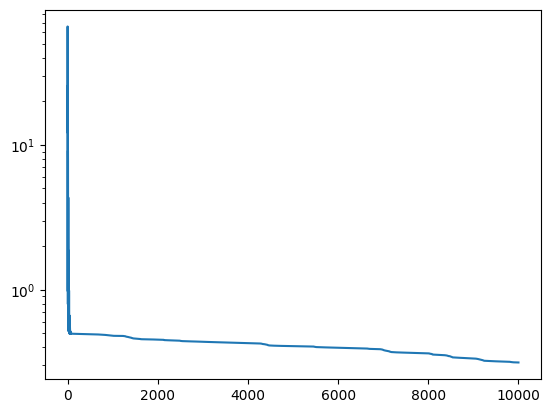

In [9]:
plt.semilogy(loss_hist)

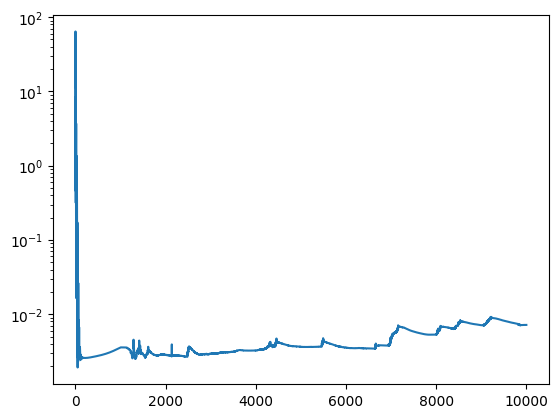

In [10]:
plt.semilogy(loss_res_hist)

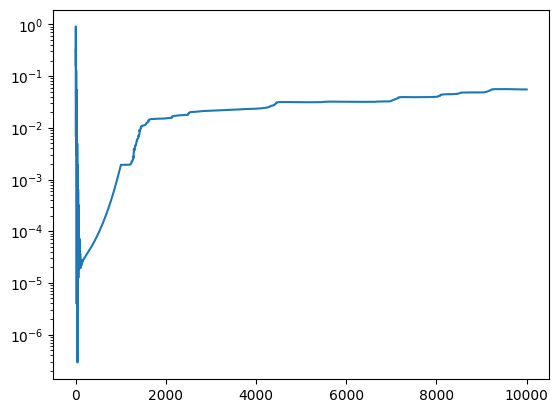

In [11]:
plt.semilogy(loss_bc_hist)

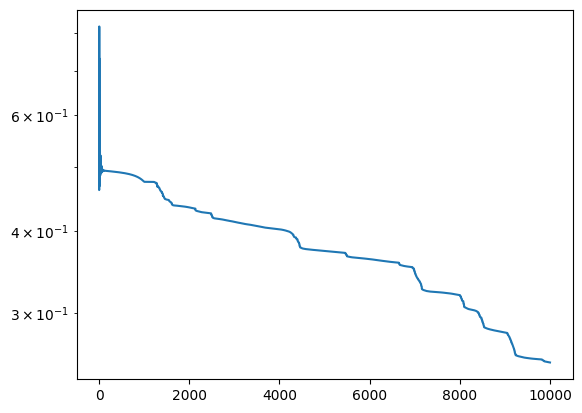

In [12]:
plt.semilogy(loss_ic_hist)

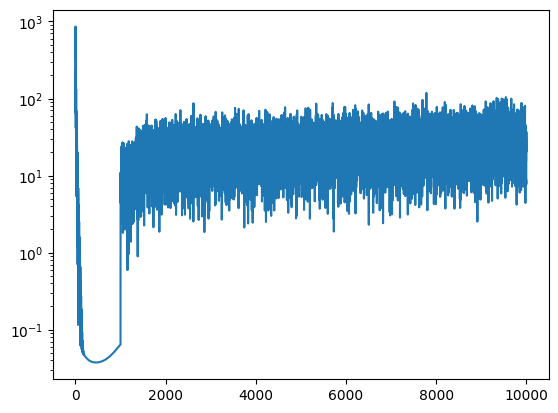

In [13]:
plt.semilogy(grad_norm_hist)